In [ ]:
# 필요한 libarary import
import json
import polars as pl
import pandas as pd
import numpy as np
from scipy.stats import norm
import re
from tqdm.auto import tqdm
from datetime import datetime, timedelta

#viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.gridspec as gridspec

# 카테고리 파생변수 생성
* Yelp의 카테고리 분류에 따라 Main & Sub 카테고리 추출
* 순서가 유의미하다고 가정하고, 앞에서부터 두 번째 등장하는 카테고리까지만 추출

In [ ]:
# business JSON file Load
business_path = "your_path"  # yelp_academic_dataset_business.json
business = pd.read_json(business_path, lines=True, orient='columns')

# split 및 공백처리
business = business.dropna(subset=["categories"])  # 카테고리 없는 행 제거
business["categories"] = business["categories"].str.split(",").apply(lambda x  :  [i.strip() for i in x] if x != None else x)

# Food에서 "Beer, Wine & Spirits"는 하나로 합쳐줘야 함
try :
  for idx, row in business.iterrows() :
    for i in range(len(row["categories"])) :
      if row["categories"][i] == "Beer" :
        row["categories"][i] = "Beer, Wine & Spirits"
        del row["categories"][i+1]
        business.at[idx, "categories"] = row["categories"]
        break
except : # category None인 경우
  pass

# business["categories"][141]  # 확인

In [ ]:
# category JSON file Load
cat_path = "your_path"  # 경로 변경
with open( cat_path, 'r') as file:
  yelp_cat = json.load(file)

# parent로 root node(main) 찾아 sub 추가
category = { c["title"]: {"alias":c["alias"], "subs":[] } for c in yelp_cat if c["parents"] == []}
for c in yelp_cat :
  base = c["parents"]
  if base :
    for title, info in category.items() :
      if info["alias"] == base[0] and c["title"] not in info["subs"] :
        info["subs"].append(c["title"])  # 해당 main에 sub카테고리로 추가
# print(category)

# main 컬럼 2개까지 추가
main1, main2 = [], []
cat_set = list(category.keys())
for cats in business["categories"]:
  temp = [ cat for cat in cats if cat in cat_set ]
  if temp : # main2는 있으면 추가
    main1.append(temp[0])
    main2.append(temp[1] if len(temp) > 1 else None)
  else :
    main1.append(None)
    main2.append(None)
print(len(main1), len(main2)) # 길이 맞는지 확인

# df에 main 카테고리 파생변수 추가
business["main1"], business["main2"] = main1, main2

# sub도 각각 2개씩 추가
main1_sub1, main1_sub2 = [], []
main2_sub1, main2_sub2 = [], []

def process_subcategories(main_subs, temp):
    if len(temp) >= 2:
        main_subs.append((temp[0], temp[1]))
    elif temp:
        main_subs.append((temp[0], None))
    else:
        main_subs.append((None, None))

for i, row in business.iterrows():
  main1_subs = category[row["main1"]]["subs"]
  main2_subs = category[row["main2"]]["subs"] if row["main2"] else []

  temp1 = [cat for cat in row["categories"] if cat in main1_subs]
  # main2 sub가 있고 이에 해당하면
  temp2 = [cat for cat in row["categories"] if main2_subs and (cat in main2_subs)]

  # main1의 sub카테고리 추가
  process_subcategories(main1_sub1, temp1)
  process_subcategories(main2_sub1, temp2)

main1_sub1, main1_sub2 = zip(*main1_sub1)
main2_sub1, main2_sub2 = zip(*main2_sub1)

# df에 sub 카테고리 파생변수 추가
business["main1_sub1"], business["main1_sub2"], business["main2_sub1"], business["main2_sub2"] = main1_sub1, main1_sub2, main2_sub1, main2_sub2
business.info()

* main1의 카테고리별 리뷰 수 분포 확인

In [ ]:
# groupby하기 위해 리스트 -> 문자열로 변환한 컬럼 추가
business['category_str'] = business['main1'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))

# 카테고리별 값 계산
x = business.groupby('category_str')['review_count'].sum()
x = x.sort_values(ascending=False)
x = x.iloc[0:20]

# 시각화
plt.figure(figsize=(16, 4))
color = sns.color_palette("winter", len(x))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette=color)
plt.title("Top 20 Main Categories", fontsize=20)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80, fontsize=16)
plt.ylabel('# counts', fontsize=12)
plt.xlabel('Category', fontsize=12)

# 텍스트 레이블 추가
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

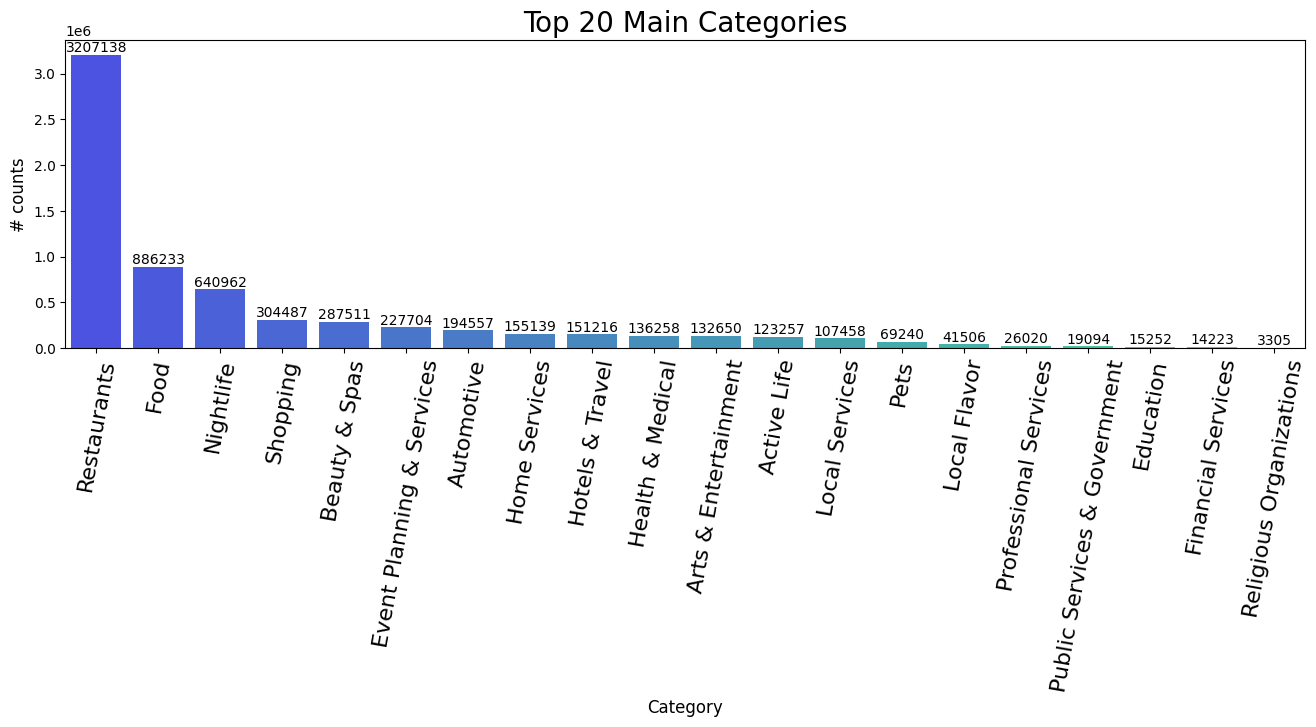

In [ ]:
# 상위 2개(Restaurant & Food) 비중
top_2 = x.iloc[0:2]
others = x.iloc[2:].sum()
data = pd.concat([top_2, pd.Series({'Others': others})])
data = data.sort_values(ascending=True)
# 파이 차트 그리기
plt.figure(figsize=(8, 8))
plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("winter", len(data)),textprops={'fontsize': 14})
plt.title('Proportion of Top 2 Main Categories vs Others', fontsize=18)
plt.show()

* Restaurants과 Food의 리뷰가 약 60%를 차지
* main1만 살펴봤을 때이므로, main2까지 고려하게 되면 그 비중은 더 클 것
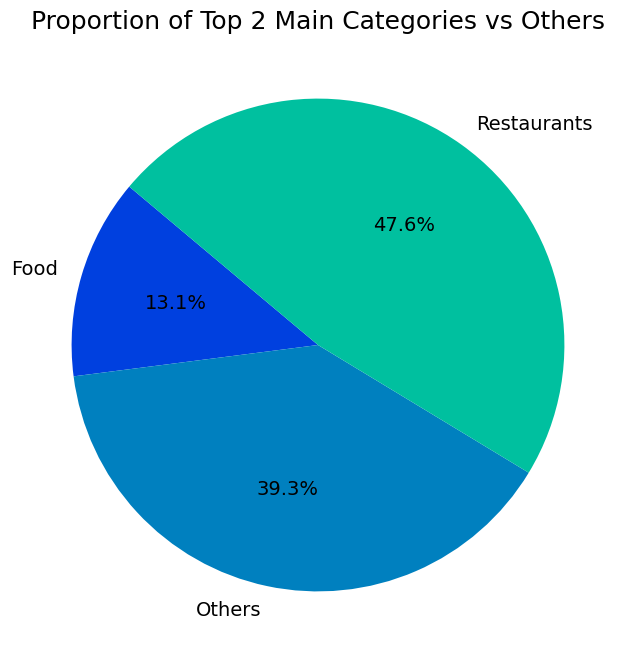

### 1) main1 or main2가 Restaurant인 경우만 sub랑 매칭
* 가장 단순한 접근

In [ ]:
biz_res = business[(business["main1"]=="Restaurants")|(business["main2"]=="Restaurants")].reset_index()
biz_res.drop(columns=["index","Unnamed: 0"], inplace = True)
biz_res

In [ ]:
col = []
for i, row in biz_res.iterrows():
  if row["main1"] == "Restaurants" : # main1이 레스토랑이면
    col.append([row["main1"], row["main1_sub1"]])
  elif row["main2"] == "Restaurants" : # main2가 레스토랑이면
    col.append([row["main2"], row["main2_sub1"]])
print(f"총: {len(biz_res)}개, 추가컬럼: {len(col)}개") # 길이 맞는지 확인

In [ ]:
biz_res["category"] = col # 컬럼 추가
print(f"Sub NaN: {len(biz_res[biz_res['category'].apply(lambda x : pd.isna(x[1]))])}개") # sub null값 확인

### 2) main1은 Restaurant(default) + main2는 Food만(opt)
* main1의 sub가 없고, main2의 sub가 있는 경우는 main2가 카테고리로서 유의미하다고 판단
* 그럴 경우 main2는 Restaurant과 유사한 범주에 있는 Food로만 대체


In [ ]:
biz_res_2 = business[(business["main1"]=="Restaurants")]
col_2 = []
for i, row in biz_res_2.iterrows():
  # main1의 sub가 비었을 때는 main2가 food인 경우만 가져다 쓰기
  if pd.isna(row["main1_sub1"]) and row["main2"] == "Food" and pd.notna(row["main2_sub1"]):
    col_2.append([row["main2"],row["main2_sub1"]])
  else : # 그 외는 main1로 쓰기
    col_2.append([row["main1"],row["main1_sub1"]])
print(f"총: {len(biz_res_2)}개, 추가컬럼: {len(col_2)}개") # 길이 맞는지 확인

In [ ]:
biz_res_2["category"] = col_2 # 컬럼 추가
print(f"Sub NaN: {len(biz_res_2[biz_res_2['category'].apply(lambda x : pd.isna(x[1]))])}개") # sub null값 확인

### 3) main1 or main2가 Restaurants, Food인 경우
* main1의 sub가 없을 때는 main2가 Restaurant, Food인 경우만 포함
* main1이 Restaurants, Food가 아닐 때 main2가 Restaurants, Food면 main2로 대체
* 그 외는 main1 기준으로 쓰기

In [ ]:
# restaurant / food 가 main으로 묶인 경우만
biz_res_fd = business[(business["main1"].isin(["Restaurants","Food"])) | (business["main2"].isin(["Restaurants","Food"]))]
col_3 = []
for i, row in biz_res_fd.iterrows():
  # main1의 sub가 비었을 때는 main2가 res,food인 경우만 가져다 쓰기
  if pd.isna(row["main1_sub1"]) and row["main2"] in ["Restaurants","Food"] and pd.notna(row["main2_sub1"]):
    col_3.append([row["main2"],row["main2_sub1"]])
  # main1이 res나 food가 아닌데 main2가 res, food면 main2로
  elif (row["main1"] not in  ["Restaurants","Food"]) and (row["main2"] in ["Restaurants","Food"]) :
    col_3.append([row["main2"],row["main2_sub1"]])
  else : # 그 외는 main1로 쓰기
    col_3.append([row["main1"],row["main1_sub1"]])
print(f"총: {len(biz_res_fd)}개, 추가컬럼: {len(col_3)}개") # 길이 맞는지 확인

In [ ]:
biz_res_fd["category"] = col_3 # 컬럼 추가
print(f"Sub NaN: {len(biz_res_fd[biz_res_fd['category'].apply(lambda x : pd.isna(x[1]))])}개") # sub null값 확인

### 3개 케이스 비교

In [ ]:
a = (len(biz_res),len(biz_res[biz_res['category'].apply(lambda x : pd.isna(x[1])) ]),biz_res["review_count"].sum())
b = (len(biz_res_2),len(biz_res_2[biz_res_2['category'].apply(lambda x : pd.isna(x[1])) ]), biz_res_2["review_count"].sum())
c = (len(biz_res_fd), len(biz_res_fd[biz_res_fd['category'].apply(lambda x : pd.isna(x[1]))]), biz_res_fd["review_count"].sum())
total = [a[0], b[0], c[0]]
nan = [a[1], b[1], c[1]]  # sub null

# 막대 그래프 생성
x = np.arange(len(total))  # x축 위치
width = 0.35  # 막대 너비
labels = ['A', 'B', 'C']

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, total, width, label='Total Length', color = "cadetblue" )
rects2 = ax.bar(x + width/2, nan, width, label='NaN Values', color = "darkslategrey" )

# 비율 계산 및 표시
for i in range(len(total)):
    ratio = (nan[i] / total[i]) * 100
    ax.text(i - width/2, total[i], f'{total[i]}', ha='center', va='bottom', fontsize=12)
    ax.text(i + width/2, nan[i], f'{nan[i]}\n({ratio:.2f}%)', ha='center', va='bottom', fontsize=12)

# x 축 및 제목 설정
ax.set_xlabel('Cases',fontsize= 12)
ax.set_ylabel('Business Count',fontsize= 12)
ax.set_title('Comparison of Cases',fontsize= 15)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

* 데이터 수가 많고 비교적 sub 카테고리 누락 없이 채워진 3번째 case로 카테고리 분포 확인

In [ ]:
biz_res_fd['category_str'] = biz_res_fd['category'].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))

# 카테고리별 값 계산
x = biz_res_fd['category_str'].value_counts()
print(f"There are {len(x)} different types/categories of Businesses in Yelp!")

# 차트 준비
x = x.sort_values(ascending=False)
x = x.iloc[0:20]

# 시각화
plt.figure(figsize=(16, 4))
color = sns.color_palette("winter", len(x))
ax = sns.barplot(x=x.index, y=x.values, alpha=0.8, palette=color)
plt.title("Top 20 Categories of Restaurants", fontsize=20)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80, fontsize=16)
plt.ylabel('# counts', fontsize=12)
plt.xlabel('Category', fontsize=12)

# 텍스트 레이블 추가
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

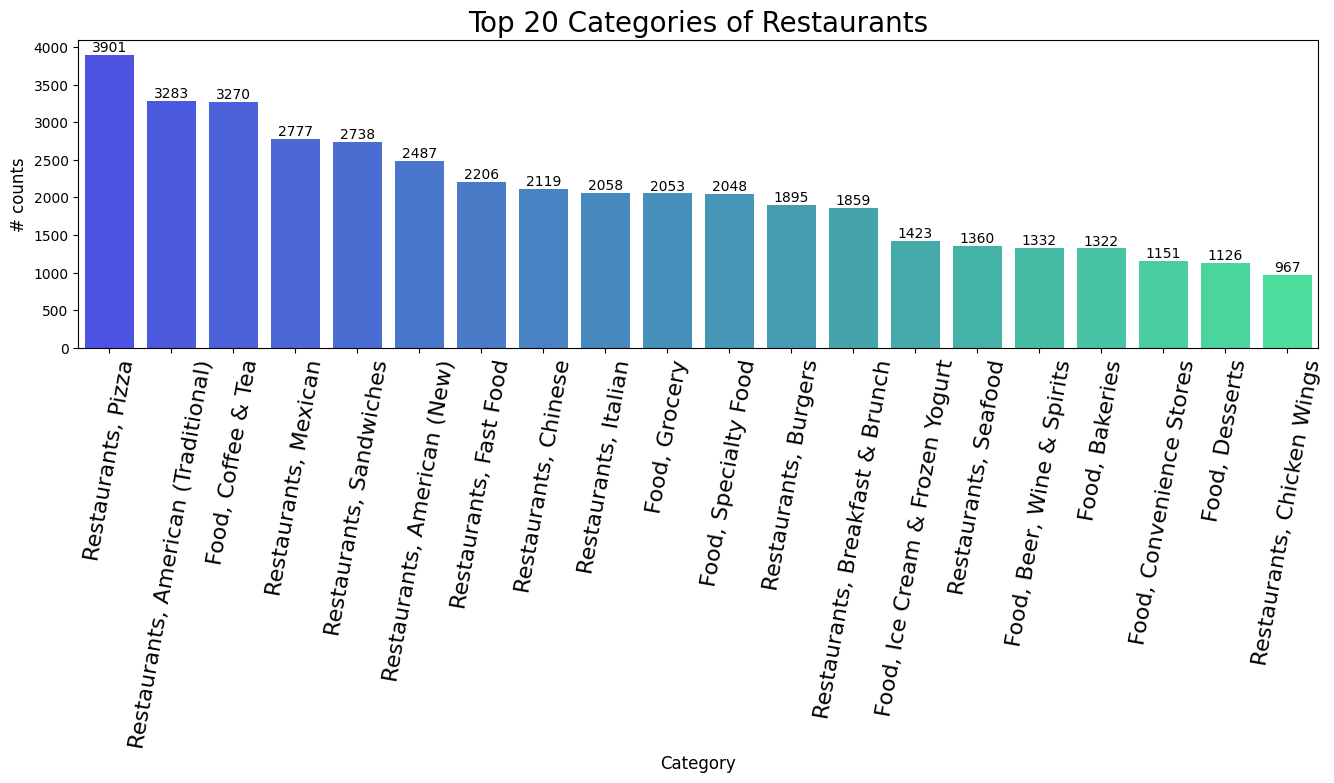